In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

!pip install atari-py

Consult https://github.com/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb 

Especially for running visualization

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS  rars/
!mv ROMS  rars/
!python -m atari_py.import_roms rars

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [14]:
import numpy as np
import gym

# gym initialization
env = gym.make("Pong-v4")
observation = env.reset()
prev_input = None

# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

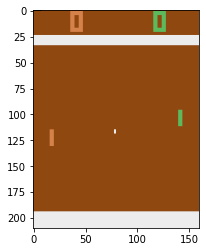

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt

env = gym.make("Pong-v4")  # environment info
observation = env.reset()
# The ball is released after 20 frames
for i in range(22):

  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)

In [16]:
#Preprocessing function
def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195]  # crop
  I = I[::2, ::2, 0]  # downsample by factor of 2
  I[I == 144] = 0  # erase background (background type 1)
  I[I == 109] = 0  # erase background (background type 2)
  I[I != 0] = 1  # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()


In [ ]:
#Show preprocessed
obs_preprocessed = prepro(observation).reshape(80,80)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

Original Floyd Approach at https://blog.floydhub.com/spinning-up-with-deep-reinforcement-learning/

Also consider https://github.com/mrahtz/tensorflow-rl-pong/blob/master/pong.py



In [ ]:
# reward discount used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def discount_rewards(r, gamma):
  """ take 1D float array of rewards and compute discounted reward """
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0
  # we go from last reward to first one so we don't have to do exponentiations
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
    running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
    discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r

"""
The function works thusly: negative rewards are spread to the frames before our model missed the ball (before the -1.0 in reward), idem for the positive.

Essentially, we set the reward of actions taken before each reward, similar to the reward obtained.

for example if we got reward +1 at time 200, we say that reward of time 199 is +0.99, reward of time 198 is +0.98 and so on.

But note that the list created will have all 21 points of interactions done. So you have multiple lives here within a single term. Have to work out how this method works exactly
"""

In [25]:
# import necessary modules from keras
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import Adam

# creates a generic neural network architecture

"""
The 80 * 80 input dimension comes from the pre-processing of the raw pixels made by Karpathy (the only important pixels are the balls and the paddle)
Input here represents the difference in pixels betewen one frame and another, giving you direction of agents and ball. Encoded in Karpathy's own preprocessing functions

TODO, try adding a 400 layer infront of the 200 unit layer
"""


model = Sequential()

# hidden layer takes a pre-processed frame as input, and has 200 units. Simple layer architectur of 200 x1, 1x1
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))

# output layer - we use a Sigmoid here, in order to get a 0, or 1 value to represent ACTION UP
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))

# compile the model using traditional Machine Learning losses and optimizers
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1280200   
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = []
observation = env.reset()
prev_input = None
# main training loop
while (True):

    """
    Start by preprocessing the observation frame, and then doing the difference with the previous frame. Naturally if frame 1 then we subtract by zeros
    
    X here is the frame-frame difference, Y is the next action (kind of like an RNN). We are trying to predict the next action given two observations.
    """
    cur_input = prepro(observation)
    #print(len(cur_input)) - Sanity Check reasons only
    
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    # forward the policy network and sample action according to the probability distribution
    """
    Running model.predict to know what the current model thinks about the probability of doing the UP_ACTION, given the current frame setting.
    
    Double check size and shape of the array here im pretty sure its for bias term?
    Keras requires a third?? dimension perhaps hre
    """
    
    
    proba = model.predict(np.expand_dims(x, axis=1).T)
    # proba=model.predict(np.expand_dims(x.reshape(80,80), axis=0)) 2D model stuff DELETE
    
    
    #Intorucing another probability distirubtion here, not sure
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment - This is returned by our environment in OpenAI gym.  
    observation, reward, done, info = env.step(action)
    #Note how AT EACH STEP A REWARD IS CALCULATED. THIS IS NOT EACH GAME BUT EACH FRAME-FRAME DIFFERENCE.  MOST OF THE TIME THIS IS 0
    #THESE REWARDS ARE USED TO ENCOURAGE OR DISCOURAGE MOVEMENTS
    rewards.append(reward)
    reward_sum += reward
    
    """
    rewards : to each frame (x_train[frame_number]) and action (y_train[frame_number]) 
    is associated a reward (-1 if it missed the ball, 0 if nothing happens, and 1 if opponent misses the ball), so we get for instance the following array:
    """
    
    # end of an episode - The GYM also invokes DONE automatically. Invoked when one player reaches 21
    if done:
        
        history.append(reward_sum)
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
        if episode_nb>=3000 and reward_sum >=-12:
          break
        else:
          
        
          # increment episode number
          episode_nb += 1
        
          # training
          model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
        
          """
          If an action leads to a positive reward, it tunes the weights of the neural network so it keeps on predicting this winning action.
          Otherwise, it tunes them in the opposite way


          The function discount_rewards transforms the list of rewards so that even actions that remotely lead to positive rewards are encouraged. THIS IS IMPORTANT
          OTHERWISE WE WOULD SIMPLY BE TRYING TO REPLICATE RANDOM MOVEMENTS

          sample_weights is used to provide a weight for each training sample. 
          That means that you should pass a 1D array with the same number of elements as your training samples (indicating the weight for each of those samples. NOTE THIS IS NOT CLASS WEIGHTS
          """
                                                             
          # Reinitialization
          x_train, y_train, rewards = [],[],[]
          observation = env.reset()
          reward_sum = 0
          prev_input = None

In [ ]:
#Plot results - remember to call keyboard interrupt before this
plt.plot(history)
plt.show()

In [ ]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
#Evaluate model on openAi GYM
#To do this consult https://github.com/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb
env = wrap_env(gym.make('Pong-v0'))
observation = env.reset()
new_observation = observation
prev_input = None
done = False
while True:
  if True:

    #set input to network to be difference image
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input

    # Sample an action (policy)
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION

    env.render()
    # Return action to environment and extract
    #next observation, reward, and status
    observation = new_observation
    new_observation, reward, done, info = env.step(action)
    if done:
      #observation = env.reset()
      break

env.close()
show_video()
